In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cross_validation import cross_val_score
# from sklearn.model_selection import cross_val_score     did not work...need to update sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [4]:
# Read the csvs
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Create numpy arrays for values (i.e. pixels)
trainVals = train.values[:,1:]
testVals = test.values

# Create numpy array for target labels
targets = train.values[:,0]

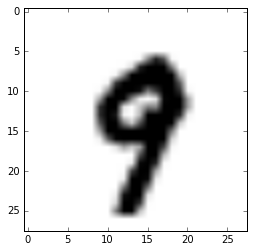

In [7]:
plt.imshow(trainVals[28,].reshape(28,28),cmap='Greys')

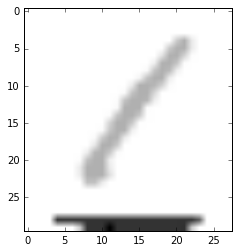

In [5]:
def sumAbsValDif(v):
    shifted_v = np.delete(v,0)
    v = np.delete(v,27)
    diff = np.subtract(shifted_v,v)
    return sum([abs(x) for x in diff])

def addNewBumpFeature(oldImage):
    imageMatrix = oldImage.reshape(28,28)
    oldImageList = list(deepcopy(oldImage))
    for j in range(28):
        oldImageList.append(sumAbsValDif(imageMatrix[j,]))
    for j in range(28):
        oldImageList.append(sumAbsValDif(imageMatrix[:,j]))
    imagePlusFeatures = oldImageList
    return imagePlusFeatures

oldImage = trainVals[0,]
imagePlusFeatures = addNewBumpFeature(oldImage)
plt.imshow(np.reshape(imagePlusFeatures,newshape=(30,28)),cmap='Greys')

In [6]:
newTrainVals = []
for i in range(0,len(trainVals)):
    oldImagei = trainVals[i,]
    newTrainVals.append(addNewBumpFeature(oldImagei))

newTrainVals = np.reshape(newTrainVals, newshape = (len(trainVals),840))

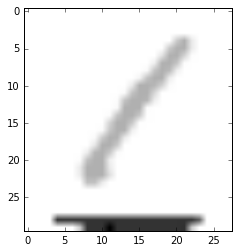

In [7]:
plt.imshow(newTrainVals[0,].reshape(30,28),cmap='Greys')

In [117]:
# Set LDA model
lda = LDA()

# get scores for 10-fold cross validation of
#   LDA model run on training data that is fitted to target labels
scores = cross_val_score(lda, newTrainVals, targets, cv=10)

C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-

In [118]:
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.92106515  0.91127498  0.92479772  0.92168531  0.92071429  0.91521791
  0.91283639  0.922802    0.92850334  0.92302193]


In [119]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.92


In [8]:
trainVals1s = deepcopy(trainVals)

trainVals1s[trainVals1s>0] = 1

In [9]:
newTrainVals1s = []
for i in range(0,len(trainVals1s)):
    oldImagei = trainVals1s[i,]
    newTrainVals1s.append(addNewBumpFeature(oldImagei))

newTrainVals1s = np.reshape(newTrainVals1s, newshape = (len(trainVals1s),840))

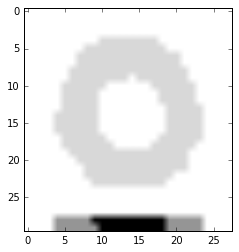

In [10]:
plt.imshow(newTrainVals1s[1,].reshape(30,28),cmap='Greys')

In [123]:
# get scores for 10-fold cross validation of
#   LDA model run on training data that is fitted to target labels
scores = cross_val_score(lda, newTrainVals1s, targets, cv=10)

C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\lance\Anaconda3\lib\site-

In [124]:
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.91892534  0.9141294   0.92170395  0.91287789  0.9197619   0.91140748
  0.91521791  0.91470098  0.92183031  0.9099142 ]


In [125]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.92


I noticed a pattern in the two new 28 pixel rows of each image that will help us to define the number of regions and the number of complete circles (equivalent to the number of regions - 1).

In [11]:
def condensedComboBumps(bumps):
    a = bumps.T
    uniqueComboBumps = [list(a[0,])]
    for i in range(1,len(a)):
        if (a[i,] != a[i-1,]).any():
            uniqueComboBumps.append(list(a[i,]))
    
    return uniqueComboBumps

def addRegionCountFeature(image):
    imageMatrix = image.reshape(30,28)
    imageList = list(deepcopy(image))
    bumps = imageMatrix[28:30,]
    diff = condensedComboBumps(bumps)
    
    numCircles = 0
    #imageList.append(numRegions)
    imagePlusFeature = imageList
    return imagePlusFeatures, numCircles, diff

0 [[0, 0], [4, 0], [4, 2], [4, 4], [2, 2], [4, 4], [2, 2], [2, 0], [0, 0]]


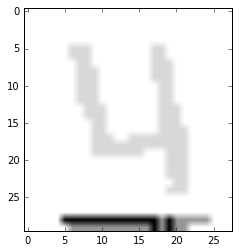

In [12]:
image = newTrainVals1s[3,]
imagePlusFeature, numCircles, diff = addRegionCountFeature(image)

print(numCircles, diff)
plt.imshow(image.reshape(30,28),cmap='Greys')

0 [[0, 0], [2, 0], [2, 2], [4, 2], [4, 4], [2, 2], [0, 2], [0, 0]]


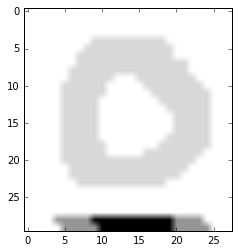

In [13]:
image = newTrainVals1s[4,]
imagePlusFeature, numCircles, diff = addRegionCountFeature(image)

print(numCircles, diff)
plt.imshow(image.reshape(30,28),cmap='Greys')